In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy import geocoders
from sklearn.utils import resample

In [2]:
df = pd.read_csv("./weatherAUS.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [3]:
def ynToInt(val):
    return 0 if val == "No" else 1
df['RainToday'] = df['RainToday'].apply(ynToInt)
df['RainTomorrow'] = df['RainTomorrow'].apply(ynToInt)

def dirToInt(dir):
    if pd.isna(dir):
        return dir
    dirMap = {
        "N":0,
        "NNE": 1,
        "NE": 2,
        "ENE":3,
        "E": 4,
        "ESE": 5,
        "SE":6,
        "SSE":7,
        "S":8,
        "SSW":9,
        "SW":10,
        "WSW":11,
        "W":12,
        "WNW":13,
        "NW":14,
        "NNW":15,
    }
    return dirMap[dir]

df['WindGustDir'] = df['WindGustDir'].apply(dirToInt)
df['WindDir9am'] = df['WindDir9am'].apply(dirToInt)
df['WindDir3pm'] = df['WindDir3pm'].apply(dirToInt)

In [4]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')

In [5]:
# split data by time
df_morn = df.drop(columns=["WindDir3pm", "WindSpeed3pm", "Humidity3pm", "Pressure3pm", "Cloud3pm", "Temp3pm"])
df_morn = df_morn.rename(columns={"WindDir9am": "WindDir", "WindSpeed9am": "WindSpeed", "Humidity9am":"Humidity", "Pressure9am":"Pressure", "Cloud9am":"Cloud", "Temp9am":"Temp"})
df_morn["is9AM"] = 1

df_aft = df.drop(columns=["WindDir9am", "WindSpeed9am", "Humidity9am", "Pressure9am", "Cloud9am", "Temp9am"])
df_aft = df_aft.rename(columns={"WindDir3pm": "WindDir", "WindSpeed3pm": "WindSpeed", "Humidity3pm":"Humidity", "Pressure3pm":"Pressure", "Cloud3pm":"Cloud", "Temp3pm":"Temp"})
df_aft["is9AM"] = 0

df_split = pd.concat((df_morn, df_aft))
df_split.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir,WindSpeed,Humidity,Pressure,Cloud,Temp,RainToday,RISK_MM,RainTomorrow,is9AM
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,12.0,44.0,12.0,20.0,71.0,1007.7,8.0,16.9,0,0.0,0,1
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,13.0,44.0,15.0,4.0,44.0,1010.6,NaN,17.2,0,0.0,0,1
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,11.0,46.0,12.0,19.0,38.0,1007.6,NaN,21.0,0,0.0,0,1
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,2.0,24.0,6.0,11.0,45.0,1017.6,NaN,18.1,0,1.0,0,1
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,12.0,41.0,3.0,7.0,82.0,1010.8,7.0,17.8,0,0.2,0,1


In [6]:
# remove locations missing the pressure field
df_location = df_split.groupby(df_split['Location']).aggregate(sum)
good_locations = df_location[df_location["Pressure"] > 0].index

df_pressure = df_split[df_split["Location"].isin(good_locations)]

In [7]:
na_percentage = (df_pressure.isnull().sum()/df_pressure.isnull().count()).sort_values(ascending=False)
na_percentage

Sunshine         0.538263
Evaporation      0.492603
Cloud            0.410433
WindGustDir      0.058816
WindGustSpeed    0.058280
WindDir          0.050853
Pressure         0.032447
Rainfall         0.028727
RISK_MM          0.028722
Humidity         0.025232
WindSpeed        0.022176
Temp             0.020518
MinTemp          0.014278
MaxTemp          0.014008
RainTomorrow     0.000000
Date             0.000000
RainToday        0.000000
Location         0.000000
is9AM            0.000000
dtype: float64

In [8]:
# Remove columns with more than 20% n/a values
df_20 = df_pressure.drop(columns=na_percentage[na_percentage > 0.2].index)
df_20.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir,WindSpeed,Humidity,Pressure,Temp,RainToday,RISK_MM,RainTomorrow,is9AM
0,2008-12-01,Albury,13.4,22.9,0.6,12.0,44.0,12.0,20.0,71.0,1007.7,16.9,0,0.0,0,1
1,2008-12-02,Albury,7.4,25.1,0.0,13.0,44.0,15.0,4.0,44.0,1010.6,17.2,0,0.0,0,1
2,2008-12-03,Albury,12.9,25.7,0.0,11.0,46.0,12.0,19.0,38.0,1007.6,21.0,0,0.0,0,1
3,2008-12-04,Albury,9.2,28.0,0.0,2.0,24.0,6.0,11.0,45.0,1017.6,18.1,0,1.0,0,1
4,2008-12-05,Albury,17.5,32.3,1.0,12.0,41.0,3.0,7.0,82.0,1010.8,17.8,0,0.2,0,1


In [9]:
# impute columns with mean
df_imputed = df_20.copy()
for column in df_imputed.select_dtypes(include=['float64']).columns:
    df_imputed[column] = df_imputed[column].fillna(df_imputed[column].mean())
df_imputed.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir,WindSpeed,Humidity,Pressure,Temp,RainToday,RISK_MM,RainTomorrow,is9AM
0,2008-12-01,Albury,13.4,22.9,0.6,12.0,44.0,12.0,20.0,71.0,1007.7,16.9,0,0.0,0,1
1,2008-12-02,Albury,7.4,25.1,0.0,13.0,44.0,15.0,4.0,44.0,1010.6,17.2,0,0.0,0,1
2,2008-12-03,Albury,12.9,25.7,0.0,11.0,46.0,12.0,19.0,38.0,1007.6,21.0,0,0.0,0,1
3,2008-12-04,Albury,9.2,28.0,0.0,2.0,24.0,6.0,11.0,45.0,1017.6,18.1,0,1.0,0,1
4,2008-12-05,Albury,17.5,32.3,1.0,12.0,41.0,3.0,7.0,82.0,1010.8,17.8,0,0.2,0,1


In [10]:
# add coordinates
def get_loc_map(cities):
    res = {}
    geolocator = geocoders.Nominatim(user_agent='test')
    for city in cities:
        if (city == "PearceRAAF"):
            city_split = "Pearce RAAF"
        else:
            city_split = ''.join(' ' + char if char.isupper() else char.strip() for char in city).strip()
        res[city] = geolocator.geocode("{}, AU".format(city_split))
    
    return res
loc_map = get_loc_map(df_imputed.Location.unique())

df_imputed["Latitude"] = df_imputed["Location"].map(lambda x: loc_map[x].latitude)
df_imputed["Longitude"] = df_imputed["Location"].map(lambda x: loc_map[x].longitude)

In [11]:
df_imputed.to_csv("weatherAUS_cleaned.csv", index=False)

In [12]:
df_majority_0 = df_imputed[(df_imputed['RainTomorrow']==0)] 
df_minority_1 = df_imputed[(df_imputed['RainTomorrow']==1)] 
df_minority_upsampled = resample(df_minority_1, 
                                 replace=True,    
                                 n_samples=len(df_imputed[(df_imputed['RainTomorrow']==0)]),
                                 random_state=402) 

df_upsampled = pd.concat([df_minority_upsampled, df_majority_0])
df_upsampled.to_csv("weatherAUS_cleaned_upsampled.csv", index=False)

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MinTemp,213597.0,12.013287,6.437902,-8.7,7.4,11.8,16.7,33.9
MaxTemp,213784.0,23.132537,7.139490,-4.1,17.9,22.5,28.1,48.9
Rainfall,210781.0,2.333787,8.547405,0.0,0.0,0.0,0.6,474.0
Evaporation,101279.0,5.489808,4.226591,0.0,2.6,4.8,7.4,138.7
Sunshine,92165.0,7.617073,3.771815,0.0,4.8,8.5,10.6,14.5
WindGustDir,200813.0,7.544452,4.478363,0.0,4.0,8.0,11.0,15.0
WindGustSpeed,200920.0,40.029041,13.577398,2.0,31.0,39.0,48.0,135.0
WindDir9am,200103.0,7.255383,4.647503,0.0,3.0,7.0,11.0,15.0
WindDir3pm,207905.0,7.630827,4.493017,0.0,4.0,8.0,12.0,15.0
WindSpeed9am,212983.0,14.035618,8.886909,0.0,7.0,13.0,19.0,87.0


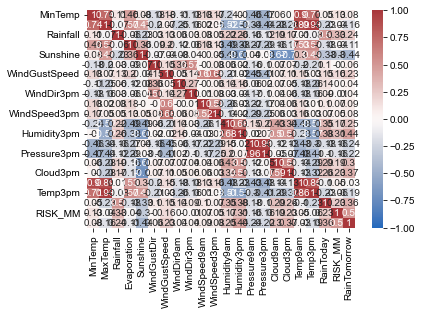

In [14]:
matrix = df.corr().round(2)
sns.heatmap(matrix, annot=True,vmax=1, vmin=-1, center=0, cmap='vlag')
sns.set(rc={'figure.figsize':(24,24)})
plt.show()